CSV File Academic Style Bar Chart Generator
Reading CSV files from /home/daozhang/Draw_picture/Kidney_result folder...
Successfully read: scDIFF-noH3k4me1
Successfully read: scDIFF-noH3k4me3
Successfully read: scDIFF
Successfully read: scDIFF-noH3k27ac
Successfully read: scDIFF-noepi
Successfully read 5 method files

Available metrics: ['ACC', 'Kappa', 'Weighted_F1', 'Macro_F1']

Extracting Kappa metric data...

Kappa Data Summary:
Number of datasets: 5
Number of methods: 5
Datasets: ['KidneyA', 'KidneyB', 'KidneyC', 'KidneyD', 'KidneyE']
Methods: ['scDIFF-noH3k4me1', 'scDIFF-noH3k4me3', 'scDIFF-noH3k27ac', 'scDIFF-noepi', 'scDIFF']

Kappa values for each method on each dataset:
--------------------------------------------------------------------------------
Method              KidneyA     KidneyB     KidneyC     KidneyD     KidneyE     
--------------------------------------------------------------------------------
scDIFF-noH3k4me1    0.889       0.962       0.960       0.933       0

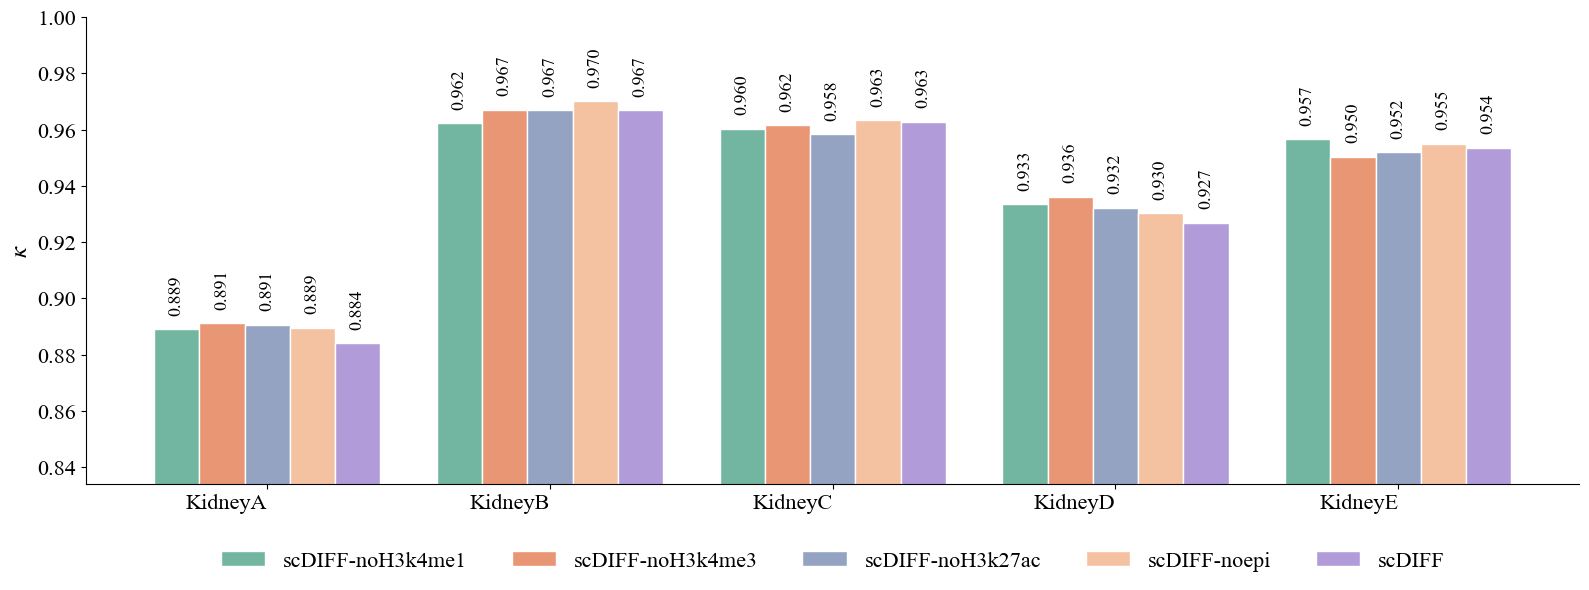


Complete! Chart has been generated.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
# Fix font settings for mathematical symbol rendering
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Computer Modern Roman'],
    'mathtext.fontset': 'stix',  # Use STIX font set for better Greek letter support
    'mathtext.rm': 'serif',
    'mathtext.it': 'serif:italic',
    'mathtext.bf': 'serif:bold',
    'text.usetex': False,  # Ensure no LaTeX dependency
    'axes.unicode_minus': False  # Prevent minus sign display issues
})

# Define metric label mappings
metric_labels = {
    # Accuracy related - use concise symbols
    'ACC': r'$Acc$',
    'Accuracy': r'$Acc$',
    'Acc': r'$Acc$',
    
    # Kappa coefficient
    'Kappa': r'$\kappa$',
    'kappa': r'$\kappa$',
    'Cohen_Kappa': r'$\kappa$',
    
    # F1 score related - use concise symbols
    'Weighted_F1': r'$wF1$',
    'wF1': r'$wF1$',
    'WeightedF1': r'$wF1$',
    'Macro_F1': r'$mF1$',
    'mF1': r'$mF1$',
    'MacroF1': r'$mF1$',
    'F1': r'$F1$',
    'F1_Score': r'$F1$',
}

def read_csv_files(folder_path):
    """
    Read all CSV files in the specified folder
    
    Args:
        folder_path (str): Path to the folder containing CSV files
    
    Returns:
        dict: Dictionary of method names and corresponding data
    """
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {folder_path} folder")
        return {}
    
    method_data = {}
    
    for csv_file in csv_files:
        # Extract method name from filename
        method_name = Path(csv_file).stem
        
        try:
            # Read CSV file
            df = pd.read_csv(csv_file)
            
            # Check file format
            if 'Dataset' in df.columns:
                # If Dataset column exists, each row represents results for one dataset
                method_data[method_name] = df
            else:
                # If no Dataset column, assume first column is dataset name, others are metrics
                df.columns = ['Dataset'] + list(df.columns[1:])
                method_data[method_name] = df
                
            print(f"Successfully read: {method_name}")
            
        except Exception as e:
            print(f"Error reading file {csv_file}: {e}")
    
    return method_data

def reorder_methods_with_scDIFF_last(methods):
    """
    Move scDIFF method to the end while maintaining original order of other methods
    
    Args:
        methods (list): Original method list
    
    Returns:
        list: Reordered method list
    """
    # Only find methods named exactly "scDIFF"
    scdiff_method = [method for method in methods if method == 'scDIFF']
    other_methods = [method for method in methods if method != 'scDIFF']
    
    # Return reordered list: other methods + scDIFF methods
    return other_methods + scdiff_method

def extract_metric_from_files(method_data, metric='Kappa'):
    """
    Extract specified metric data from multiple method files
    
    Args:
        method_data (dict): Dictionary of method names and corresponding DataFrames
        metric (str): Name of the metric to extract
    
    Returns:
        tuple: (dataset names list, method names list, dictionary of values for each method per dataset)
    """
    if not method_data:
        return [], [], {}
    
    # Get all dataset names (from the first method file)
    first_method = list(method_data.keys())[0]
    first_df = method_data[first_method]
    
    if 'Dataset' in first_df.columns:
        # If Dataset column exists, get dataset names from it
        datasets = first_df['Dataset'].tolist()
    else:
        # Otherwise use row indices as dataset names
        datasets = [f"Dataset_{i+1}" for i in range(len(first_df))]
    
    # Get original method list and reorder
    original_methods = list(method_data.keys())
    methods = reorder_methods_with_scDIFF_last(original_methods)
    
    result_data = {}
    
    # Extract metric data for each method
    for method in methods:
        df = method_data[method]
        method_values = []
        
        if metric in df.columns:
            # Get data directly from metric column
            values = df[metric].tolist()
            for val in values:
                try:
                    method_values.append(float(val))
                except (ValueError, TypeError):
                    method_values.append(0.0)
        else:
            # If metric column not found, fill with zeros
            print(f"Warning: {metric} column not found in {method}")
            method_values = [0.0] * len(datasets)
        
        result_data[method] = method_values
    
    return datasets, methods, result_data

def create_academic_bar_chart(datasets, methods, method_data, metric='Kappa', 
                            figsize=(16, 6), save_prefix='figure'):
    """
    Create academic style bar chart
    """
    # Academic style color scheme
    colors = ['#72B6A1', '#E99675', '#95A3C3', '#F4C2A1', '#B19CD9', 
              '#FFB6C1', '#98FB98', '#DDA0DD', '#F0E68C', '#87CEEB']
    
    # Ensure enough colors
    while len(colors) < len(methods):
        colors.extend(colors)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    x = np.arange(len(datasets))
    width = 0.8 / len(methods)  # Adjust bar width based on number of methods
    
    # Draw bars for each method
    bars_list = []
    for i, method in enumerate(methods):
        values = method_data[method]
        offset = (i - len(methods)/2 + 0.5) * width
        bars = plt.bar(x + offset, values, width, label=method, 
                      color=colors[i], edgecolor='white', linewidth=1)
        bars_list.append((bars, values))
    
    # Add value labels - rotated 90 degrees for vertical display
    for i, (bars, values) in enumerate(bars_list):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:  # Only show non-zero values
                plt.text(bar.get_x() + bar.get_width()/2., 
                        height + 0.005,  # Adjust distance from bar top: 0.01 means 0.01 units from bar top
                        f'{height:.3f}', 
                        ha='center', va='bottom', 
                        fontsize=13,  # Increase value label font size
                        fontweight='normal', rotation=90)
    
    # Get current axis object
    ax = plt.gca()
    
    # Remove right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Set chart properties - use mathematical symbols as Y-axis labels
    y_label = metric_labels.get(metric, metric)  # Use original label if mapping not found
    plt.ylabel(y_label, fontsize=18, fontweight="bold")  # Increase Y-axis label font size
    plt.xticks(x, datasets, fontsize=16, rotation=0, ha='right')  # Increase X-axis label font size
    plt.yticks(fontsize=16)  # Increase Y-axis tick font size
    
    # Modified y-axis range setting - truncate for all metrics
    all_values = [val for values in method_data.values() for val in values if val > 0]
    if all_values:
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Apply truncation logic for all metrics
        if metric in ['ACC', 'Accuracy', 'Kappa']:
            # For 0-1 range metrics, keep original logic
            y_min = max(0, min_val - 0.05)
            y_max = min(1.0, max_val + 0.03)
        else:
            # For other metrics, apply similar truncation logic
            margin = (max_val - min_val) * 0.4  # Set margin to 5% of value range, reduce truncation
            y_min = max(0, min_val - margin)  # Lower bound not below 0
            y_max = max_val + margin
        
        plt.ylim(y_min, y_max)
    
    # Set legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), 
              fontsize=16, ncol=min(len(methods), 5), frameon=False)  # Increase legend font size
    
    # Adjust layout
    plt.tight_layout()
    
    # Save images - COMMENTED OUT
    # svg_path = f'{save_prefix}_{metric}.svg'
    # png_path = f'{save_prefix}_{metric}.png'
    # 
    # plt.savefig(svg_path, format='svg', dpi=1200, bbox_inches='tight')
    # plt.savefig(png_path, format='png', dpi=1200, bbox_inches='tight')
    # 
    # print(f"Charts saved:")
    # print(f"  SVG: {svg_path}")
    # print(f"  PNG: {png_path}")
    
    # Display chart
    plt.show()

def print_data_summary(datasets, methods, method_data, metric):
    """
    Print data summary
    """
    print(f"\n{metric} Data Summary:")
    print("=" * 80)
    print(f"Number of datasets: {len(datasets)}")
    print(f"Number of methods: {len(methods)}")
    print(f"Datasets: {datasets}")
    print(f"Methods: {methods}")
    
    print(f"\n{metric} values for each method on each dataset:")
    print("-" * 80)
    
    # Create table display
    header = f"{'Method':<20}" + "".join([f"{ds:<12}" for ds in datasets[:6]])  # Only show first 6 datasets
    if len(datasets) > 6:
        header += "..."
    print(header)
    print("-" * len(header))
    
    for method in methods:
        values = method_data[method]
        row = f"{method:<20}" + "".join([f"{val:<12.3f}" for val in values[:6]])
        if len(values) > 6:
            row += "..."
        print(row)

def main():
    """
    Main function
    """
    print("CSV File Academic Style Bar Chart Generator")
    print("=" * 40)
    
    # Set folder path - use default
    folder_path = "/home/daozhang/Draw_picture/Kidney_result" # change as needed
    
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist, please check if the path is correct.")
        return
    
    # Read CSV files
    print(f"Reading CSV files from {folder_path} folder...")
    method_data = read_csv_files(folder_path)
    
    if not method_data:
        print("No valid CSV files found, program exits.")
        return
    
    print(f"Successfully read {len(method_data)} method files")
    
    # Check column names of first file, show available metrics
    first_method = list(method_data.keys())[0]
    first_df = method_data[first_method]
    available_metrics = [col for col in first_df.columns if col != 'Dataset']
    
    print(f"\nAvailable metrics: {available_metrics}")
    
    # Select metric
    metric = input(f"Please select a metric to visualize (default: {available_metrics[0] if available_metrics else 'Kappa'}): ").strip()
    if not metric:
        metric = available_metrics[0] if available_metrics else 'Kappa'
    
    # Extract data
    print(f"\nExtracting {metric} metric data...")
    datasets, methods, result_data = extract_metric_from_files(method_data, metric)
    
    if len(methods) == 0:
        print("No valid method data found, please check CSV file format.")
        return
    
    # Display data summary
    print_data_summary(datasets, methods, result_data, metric)
    
    # Use default settings for chart generation
    figsize = (16, 6)
    save_prefix = 'kidney_result'
    
    # Create chart
    print(f"\nGenerating {metric} metric bar chart...")
    create_academic_bar_chart(datasets, methods, result_data, metric, 
                            figsize=figsize, save_prefix=save_prefix)
    
    print(f"\nComplete! Chart has been generated.")

if __name__ == "__main__":
    # Check if necessary libraries are installed
    try:
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError as e:
        print(f"Missing required library: {e}")
        print("Please run the following command to install:")
        print("pip install pandas matplotlib numpy")
    else:
        main()